In [50]:
#imports

import shlex, subprocess
import os , sys
import time

import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow import keras
import keras_tuner

from Bio import SeqIO
from pybedtools import BedTool

import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns    

In [51]:
#one hot encoding
def fasta_to_onehotencode(seq) : 
    #values = list(seq)
    #values = np.array(values)
    base2int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    # label = int(line.strip()[1])
    
    
    sequence = seq 
    # Encode sequence bases as integers, i.e. A as 0, C as 1, etc.
    sequence_int = [base2int.get(base, 9999) for base in sequence]
    
    sequence_onehot = tf.one_hot(sequence_int, depth=4)
    
        
    return sequence_onehot

In [52]:
def fastatoarray(fasta_sequences) :
    seq_array = np.zeros((1,400,4)) 
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        new_sequence = fasta_to_onehotencode(sequence) #onehotencode(sequence)
        new_sequence = np.expand_dims(new_sequence, axis =0)
        seq_array = np.vstack((seq_array,new_sequence))
    seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 
    return seq_array  

In [53]:
def get_df_m6A(path,file): 
            
        m6A = BedTool(path+ '/'+file)
        df_m6A = m6A.to_dataframe(disable_auto_names=True, names = [i for i in range(19)])
        df_m6A['abs_pos'] = df_m6A[1] - df_m6A[14] #getting the absolute position of the m6A site in the sequence
        return df_m6A

In [54]:
def m6A_onehot(path,file,df_m6A): 
    
    onehot_m6A_seq = np.zeros((1,400,5))
    m6A_file = np.zeros((1,400,1))
    seq_array = np.zeros((1,400,4)) 


    fasta_sequences = SeqIO.parse(open(path+ '/'+file),'fasta')

    for fasta in fasta_sequences:

        name, sequence = fasta.id, str(fasta.seq)

        chrom = str(name).split(':')[0]
        start = (str(name).split(':')[1]).split('-')[0]
        end=((str(name).split(':')[1]).split('-')[1]).split('(')[0]

        #filtering for the sequences which contain an m6A site
        filtered = df_m6A.loc[((df_m6A[13] == chrom) & (df_m6A[14] == int(start)) & (df_m6A[15] == int(end)))] 

        #one hot encoding the sequence
        new_sequence = fasta_to_onehotencode(sequence)
        new_sequence = np.expand_dims(new_sequence, axis =0)
        seq_array = np.vstack((seq_array,new_sequence))

        m6A_seq= np.zeros((1,400,1)) #standard m6A column
        if filtered.empty == False :
            
            #print( 'this is filtered' )
            #print(len(filtered))
            #print(filtered)
            for i in filtered.index:
                index = filtered.loc[i, 'abs_pos'] -1 
                m6A_seq[0][index] = 1 #substituting with 1 in the m6A site 
            #print(m6A_seq.shape)
        m6A_file = np.vstack((m6A_file, m6A_seq)) 


    m6A_file = np.delete(m6A_file, 0, 0)
    #print(m6A_file.shape)
    seq_array = np.delete(seq_array, 0, 0) 
    #print(seq_array.shape)

    onehot_m6A_seq = np.c_[seq_array, m6A_file]
    #print(onehot_m6A_seq.shape) # the shape needs to be addressed 
    #onehot_m6A_seq = np.delete(onehot_m6A_seq,0,0)
    #print(onehot_m6A_seq.shape)

    return onehot_m6A_seq


In [55]:
#

def getonehotencoded_files(path): 
    
    directory3 = os.listdir(path) #--> fol0,fold1....
    
    #here outside merging all diff files
    df_pos =pd.DataFrame() 
    df_neg1=pd.DataFrame() 
    df_neg2=pd.DataFrame()  
    
    positive_m6A = np.zeros((1,400,5))
    neg1_m6A = np.zeros((1,400,5))
    neg2_m6A = np.zeros((1,400,5))



    for file in directory3 : #all files 
        if '.miclip.filt.bed.out' in file : 
            if "positive" in file :
                df_pos = get_df_m6A(path,file) 

            if "negative-1" in file :
                df_neg1= get_df_m6A(path,file)
                
            if "negative-2" in file :
                df_neg2= get_df_m6A(path,file)
    #print(len(df_neg2))

    for file in directory3 :
        #print(file)

        if ((file.__contains__('positive')) & (file.__contains__('fasta'))):
            #print('positive')
            positive_m6A = m6A_onehot(path,file,df_pos ) 
            #print(positive_m6A.shape)

        if ((file.__contains__('negative-1')) & (file.__contains__('fasta'))):
            neg1_m6A = m6A_onehot(path,file,df_neg1 )         
            #print(neg1_m6A.shape)

        if ((file.__contains__('negative-2')) & (file.__contains__('fasta'))):
            neg2_m6A = m6A_onehot(path,file,df_neg2 ) 
            #print(neg2_m6A.shape)

    return positive_m6A,neg1_m6A,neg2_m6A #for one fold 



In [56]:
def prepare_raw_dataset_m6A(path, current_folder) : 
    print('Starting preparation of the dataset for %s' %current_folder)
    
    folder = current_folder #RBP
    directory2 = os.listdir(path+ '/' + folder)
    
    
    seq_list_pos = np.zeros((1,400,5))             
    seq_list_neg1 = np.zeros((1,400,5))
    seq_list_neg2 = np.zeros((1,400,5))
   

    seq_list_pos_test = np.zeros((1,400,5))             
    seq_list_neg1_test = np.zeros((1,400,5))
    seq_list_neg2_test = np.zeros((1,400,5))

    for folder2 in directory2 :#fold0, fold1.... 
        directory3 = os.listdir(path+ '/' + folder + '/' + folder2)

        if folder2 != "fold-4": #to be split into training and validation 
            #print(folder2)
            seq_list_pos_file, seq_list_neg1_file, seq_list_neg2_file = getonehotencoded_files(path+ '/' + folder + '/' + folder2)

            seq_list_pos = np.vstack((seq_list_pos, seq_list_pos_file))
            seq_list_neg1 = np.vstack((seq_list_neg1, seq_list_neg1_file))
            seq_list_neg2 = np.vstack((seq_list_neg2, seq_list_neg2_file))


        if folder2 == "fold-4":#for testing
            #print('fold4')
            seq_list_pos_test_file, seq_list_neg1_test_file, seq_list_neg2_test_file = getonehotencoded_files(path+ '/' + folder + '/' + folder2) 

            seq_list_pos_test = np.vstack((seq_list_pos_test, seq_list_pos_test_file))
            seq_list_neg1_test = np.vstack((seq_list_neg1_test, seq_list_neg1_test_file))
            seq_list_neg2_test = np.vstack((seq_list_neg2_test, seq_list_neg2_test_file)) 
            #print(seq_list_pos.shape, seq_list_neg1.shape, seq_list_neg2.shape)
                
    seq_list_pos = np.delete(seq_list_pos, 0, 0)             
    seq_list_neg1 = np.delete(seq_list_neg1, 0, 0)
    seq_list_neg2 = np.delete(seq_list_neg2, 0, 0)
    
    #print(seq_list_pos.shape, seq_list_neg1.shape, seq_list_neg2.shape)
    #print(seq_list_pos_test.shape, seq_list_neg1_test.shape, seq_list_neg2_test.shape)

    seq_list_pos_test = np.delete(seq_list_pos_test, 0, 0)             
    seq_list_neg1_test = np.delete(seq_list_neg1_test, 0, 0)
    seq_list_neg2_test = np.delete(seq_list_neg2_test, 0, 0)
    
    return seq_list_pos,seq_list_neg1,seq_list_neg2,seq_list_pos_test,seq_list_neg1_test,seq_list_neg2_test
    

#here it starts differentiating depending on the setting desired

In [57]:
def filter_m6A_from_array(tot) :
    
    tot_filt = np.zeros((1,400,5))
    
    for array in tot : 
        #print(array.shape)
        if any(array[:,4]) : 
            #print('----')
            #print((array[:,4]))
            array = np.expand_dims(array, axis =0)
            tot_filt = np.vstack((tot_filt, array)) 
    
    
    tot_filt = np.delete(tot_filt, 0, 0)  
    #print(tot_filt.shape)
    return tot_filt

In [58]:
def settingA(pos, neg1, neg2, pos_t, neg1_t, neg2_t): 
    #
    
    #positive-a: bound and containing at least an m6a site
    #negative-1-a: un-bound and containing at least an m6a site
    #negative-2-a: bound by other proteins and containing at least an m6a site
    
    #positive, now filtering just for sequences that contain m6A sites

    
    pos_filt = filter_m6A_from_array(pos)  
    #print(pos_filt.shape)
    pos_t_filt = filter_m6A_from_array(pos_t)
    #print(pos_t_filt.shape)
    neg1_filt = filter_m6A_from_array(neg1)  
    neg1_t_filt = filter_m6A_from_array(neg1_t)
    #print(neg1_t_filt.shape)
    neg2_filt = filter_m6A_from_array(neg2)  
    neg2_t_filt = filter_m6A_from_array(neg2_t)
    #print('neg2_fold4')
    #print(neg2_t_filt.shape)
    
    #after the filtering, produce the labels
    labels_pos = np.ones((np.shape(pos_filt)[0], 1))
    #print(labels_pos.shape)
    labels_pos_t = np.ones((np.shape(pos_t_filt)[0], 1))
    
    labels_neg1 = np.zeros((np.shape(neg1_filt)[0], 1))
    labels_neg1_t = np.zeros((np.shape(neg1_t_filt)[0], 1))
    
    labels_neg2 = np.zeros((np.shape(neg2_filt)[0], 1))
    labels_neg2_t = np.zeros((np.shape(neg2_t_filt)[0], 1))
    
    return pos_filt, neg1_filt, neg2_filt, pos_t_filt, neg1_t_filt, neg2_t_filt, labels_pos, labels_neg1, labels_neg2, labels_pos_t, labels_neg1_t, labels_neg2_t 
    

In [61]:
   # --------------------------- what about the labels???  PS: later thi will be part of prepare datasetm6A
def finalize_dataset(current_folder, pos, neg, pos_t, neg_t, labels_pos, labels_neg, labels_pos_t, labels_neg_t): 
    
    print('Shape of labels: \n-positive : ',np.shape(labels_pos),'\n-negative : ', np.shape(labels_neg),'\n-positive validation : ',np.shape(labels_pos_t),'\n-negative validation : ',np.shape(labels_neg_t))
    
    
    #merging datasets
    x = np.vstack((pos, neg))

    x_test = np.vstack((pos_t, neg_t))

    y = np.vstack((labels_pos, labels_neg))

    y_test = np.vstack((labels_pos_t, labels_neg_t))
    
    #creating the validation set

    #parameters 
    test_size = 0.2

    #test set

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, shuffle= True)
    x_test, y_test = shuffle(x_test, y_test, random_state=0)

    y_train = y_train.astype("float32")#actually useful?
    y_val =y_val.astype("float32")
    y_test = y_test.astype("float32")

    x_train = x_train.astype("float32")
    x_val = x_val.astype("float32")
    x_test =x_test.astype("float32")



    print('Shape of datasets: \n-training set : ',np.shape(x_train),'\n-validation set : ',np.shape(x_val),'\n-testing set : ', np.shape(x_test))
    
    #checking class ditribution in the whole dataset and training set

    print('Label frequencies among the dataset %s' %current_folder)
    plt.hist(y)
    plt.xticks(range(2))
    plt.title('Label Frequency')
    plt.show()

    plt.hist(y_train)
    plt.xticks(range(2))
    plt.title('Label Frequency training set')
    plt.show()

    plt.hist(y_val)
    plt.xticks(range(2))
    plt.title('Label Frequency validation set')
    plt.show()
    return x_train ,y_train ,x_val ,y_val ,x_test ,y_test

Starting preparation of the dataset for AARS_K562
(2667, 400, 5) (2667, 400, 5) (2667, 400, 5)
(721, 400, 5) (721, 400, 5) (721, 400, 5)
Shape of labels: 
-positive :  (164, 1) 
-negative :  (18, 1) 
-positive validation :  (35, 1) 
-negative validation :  (4, 1)
Shape of datasets: 
-training set :  (145, 400, 5) 
-validation set :  (37, 400, 5) 
-testing set :  (39, 400, 5)
Label frequencies among the dataset AARS_K562


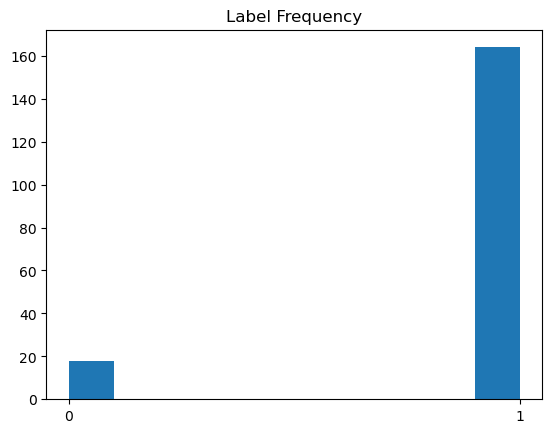

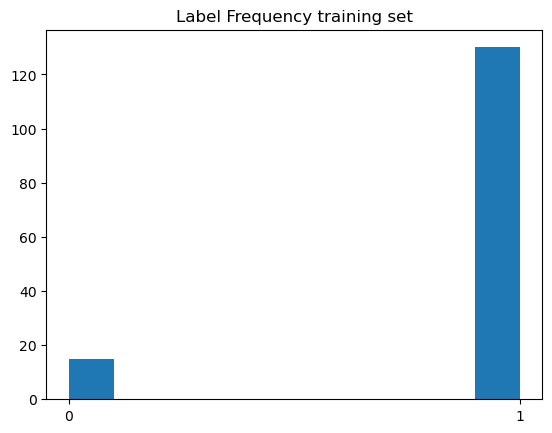

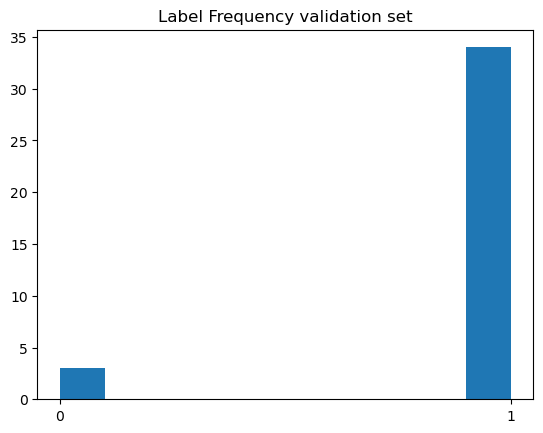

In [62]:
#Preparation of the dataset for setting A with bound and unbound sequences ( pos and neg1) 
path = '/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/'
folder = 'AARS_K562'

#getting first the onehot_enconded files 
pos,neg1,neg2,pos_t,neg1_t,neg2_t = prepare_raw_dataset_m6A(path, folder)

#preparing the files and labels following the setting A rules 
pos_filt, neg1_filt, neg2_filt, pos_t_filt, neg1_t_filt, neg2_t_filt, labels_pos, labels_neg1, labels_neg2, labels_pos_t, labels_neg1_t, labels_neg2_t = settingA(pos,neg1,neg2,pos_t,neg1_t,neg2_t)


#finalizing the dataset merging positive and the chosen negative ( either unbound - neg1- or bound to other RBPs -neg2- )
x_train ,y_train ,x_val ,y_val ,x_test ,y_test = finalize_dataset(folder, pos_filt, neg1_filt, pos_t_filt, neg1_t_filt, labels_pos, labels_neg1, labels_pos_t, labels_neg1_t)




In [65]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from numpy import argmax
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(x_train.toarray())
X_pca = pca.transform(x_train.toarray())
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

ModuleNotFoundError: No module named 'scikitplot'

In [ ]:
#the classes are unbalanced --> example 
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),#classes
                                                 y_train)#labels

model.fit(X_train, y_train, class_weight=class_weights) 